# Analisi di Clustering Gerarchico su Immagini / data curation anaysis

Attraverso la visualizzazione dei cluster e l'analisi statistica, valuteremo la qualità del raggruppamento e identificheremo eventuali pattern significativi nei dati.

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from src.clusters import HierarchicalCluster
from src import (
  hierarchical_kmeans_gpu as hkmg,
  hierarchical_sampling as hs
)



<b/> Create some sample dstribution with different densities

In [6]:

def make_ring(n, rmin, rmax):
    r = np.random.rand(n) * (rmax - rmin) + rmin
    alpha = np.random.rand(n) * 2 * np.pi
    return np.vstack([r * np.cos(alpha), r * np.sin(alpha)]).T

data = np.concatenate([
    make_ring(20000, 0.7, 1.0) + np.array([-2.2, 1.]),
    make_ring(200, 0.7, 1.0) + np.array([0., 1.]),
    make_ring(1000, 0.7, 1.0) + np.array([2.2, 1.]),
    make_ring(500, 0.7, 1.0) + np.array([-1.2, 0.2]),
    make_ring(8000, 0.7, 1.0) + np.array([1.2, 0.2]),
])

Hierarchical sampling from clusters: 100%|██████████| 300/300 [00:00<00:00, 13311.17it/s]


<b/>Run hierarchical clustering 

In [ ]:
clusters = hkmg.hierarchical_kmeans_with_resampling(
  data=torch.tensor(data, device="cuda", dtype=torch.float32),
  n_clusters=[1000, 300],
  n_levels=2,
  sample_sizes=[15, 2],
  verbose=False,
)
cl = HierarchicalCluster.from_dict(clusters)

In [ ]:
sampled_indices = hs.hierarchical_sampling(cl, target_size=20000)

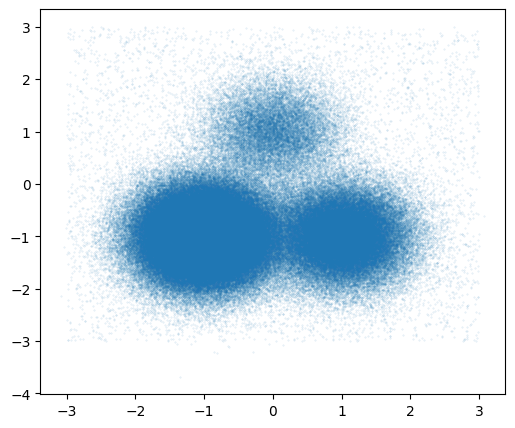

In [4]:
data = np.concatenate([
    np.random.randn(200000, 2)/2 + [-1, -1],
    np.random.randn(75000, 2)/2 + [1, -1],
    np.random.randn(20000, 2)/2 + [0, 1],
    (np.random.rand(5000,2) - 0.5) * 6,
])
#300000

figh, figw = 1, 1
fig, ax = plt.subplots(figh, figw, figsize=(6 * figw, 5))
ax.scatter(data[:, 0], data[:, 1], alpha=0.2, s = 0.1)
plt.show()

<b/> Draw test voronoi to show balanceness

Running k-means
Running 2-level hierarchical k-means
Running 3-level hierarchical k-means


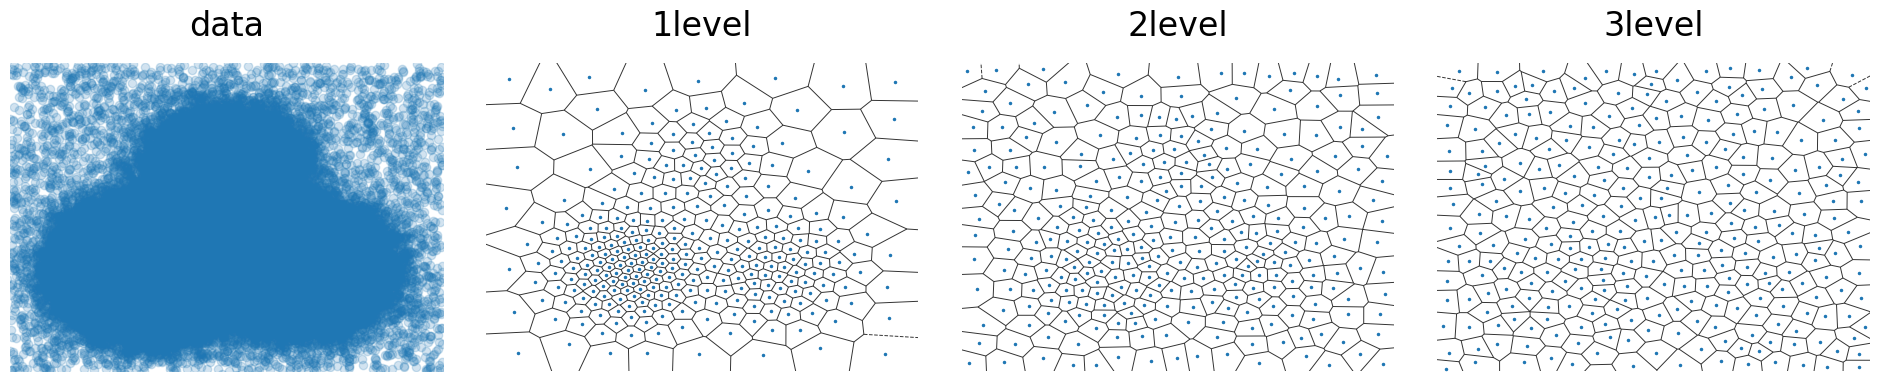

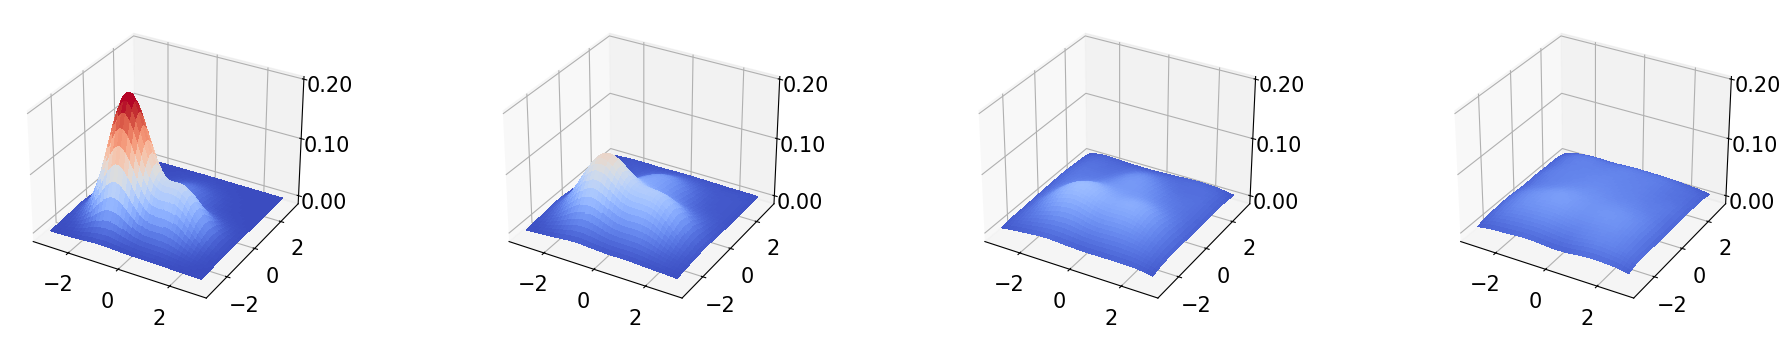

Name: data, KL divergence: 0.8657171144180577
Name: 1level, KL divergence: 0.3995633863896107
Name: 2level, KL divergence: 0.1198464651161404
Name: 3level, KL divergence: 0.040429189935540205


In [5]:
# eta: 4m30s
X = torch.tensor(data, device='cuda', dtype=torch.float32)
num_init=10
res_no_resampling = {"data": data}
print("Running k-means")
res_no_resampling["1level"] = hierarchical_kmeans(X, [300], 1, num_init=num_init, verbose=False)
print("Running 2-level hierarchical k-means")
res_no_resampling["2level"] = hierarchical_kmeans(X, [1500, 300], 2, num_init=num_init, verbose=False)
print("Running 3-level hierarchical k-means")
res_no_resampling["3level"] = hierarchical_kmeans(X, [3000, 1000, 300], 3, num_init=num_init, verbose=False)

clustering_names = ["data", "1level", "2level", "3level"]
fig = draw_voronoi(
    res_no_resampling,
    clustering_names,
    xlim=(-3, 3),
    ylim=(-3, 3),
    point_size=3,
    line_width=0.7,
    fontsize=30,
    basic_fig_size = (6,4),
)

res_no_resampling["data"] = [{"centroids": torch.tensor(data),}]
fig, kl_dist_1 = visualize_kde(
    res_no_resampling,
    clustering_names,
    legends = clustering_names,
    z_high=[0.2, 0.2, 0.2, 0.2],
    fontsize=30,
    show_title=False,
    L=3,
    basic_fig_size = (6,4),
)

In [7]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import pickle
import torch

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances as pwd
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from src.hierarchical_kmeans_gpu import hierarchical_kmeans_with_resampling, hierarchical_kmeans


def draw_voronoi(
    clusterings,
    clustering_names,
    legends = None,
    fontsize = 20,
    ylim = (-3, 3),
    xlim = (-3, 3),
    line_width=0.4,
    point_size=1,
    show_title=True,
    basic_fig_size = (6, 5),
    wspace=0.1,
    hspace=0.1,
):
    if legends is None:
        legends = clustering_names
    figh, figw = 1, len(clustering_names)
    fig, ax = plt.subplots(figh, figw, figsize=(basic_fig_size[0] * figw, basic_fig_size[1]))
    axs = ax.ravel()
    for i, _name in enumerate(clustering_names):
        if _name == "data":
            axs[0].scatter(clusterings[_name][:, 0], clusterings[_name][:, 1], alpha=0.2)
        else:
            vor = Voronoi(clusterings[_name][-1]['centroids'].cpu().numpy())
            voronoi_plot_2d(vor, ax=axs[i], show_vertices=False, point_size=point_size, line_width=line_width, line_alpha=0.8)
        if show_title:
            axs[i].set_title(legends[i], fontsize=int(fontsize * 0.8), pad=20)
        axs[i].set_ylim(ylim[0], ylim[1])
        axs[i].set_xlim(xlim[0], xlim[1])
        axs[i].axis('off')
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
    return fig

def compute_KL_divergence(kde, L, s):
    X = np.arange(-L, L, s)
    Y = np.arange(-L, L, s)
    X, Y = np.meshgrid(X, Y)
    XY = np.vstack([X.ravel(), Y.ravel()]).T
    d_u = 1/(4*L**2)
    
    d = np.exp(kde.score_samples(XY))
    d_norm = d * 1/(s**2 * d.sum())
    KL = -(d_norm * np.log(d_u/d_norm)).sum() * s**2
    return KL
    
def visualize_kde(
    clusterings,
    clustering_names,
    legends = None,
    fontsize=20,
    bandwidth=0.5,
    L=4,
    s=0.02,
    z_high=None,
    show_title=True,
    cmap_max=None,
    basic_fig_size = (6, 5),
    compute_kl = True,
    wspace=0.1,
    hspace=0.1,
):
    if z_high is None:
        z_high = [0.05] * len(clustering_names)
    if cmap_max is None:
        cmap_max = z_high
    if legends is None:
        legends = clustering_names
    kdes = {}
    for _name in clustering_names:
        kdes[_name] = KernelDensity(bandwidth=bandwidth).fit(
            clusterings[_name][-1]["centroids"].cpu().numpy()
        )
    
    fig, ax = plt.subplots(
        1, len(clustering_names),
        figsize=(basic_fig_size[0] * len(clustering_names), basic_fig_size[1]),
        subplot_kw={"projection": "3d"},
    )
    axs = ax.ravel()
    for i, _name in enumerate(clustering_names):
        X = np.arange(-L, L, 0.05)
        Y = np.arange(-L, L, 0.05)
        X, Y = np.meshgrid(X, Y)
        XY = np.vstack([X.ravel(), Y.ravel()]).T
        Z = np.exp(kdes[_name].score_samples(XY)).reshape(X.shape)
        
        _ = axs[i].plot_surface(
            X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=0, vmax=cmap_max[i],
        )
        
        axs[i].set_zlim(-0.01, z_high[i])
        axs[i].zaxis.set_major_formatter('{x:.02f}')
        if show_title:
            axs[i].set_title(legends[i], fontsize=fontsize * 8 // 10, pad=20)

        axs[i].tick_params(axis='x', which='major', labelsize=fontsize*5//10)
        axs[i].tick_params(axis='y', which='major', labelsize=fontsize*5//10)
        axs[i].tick_params(axis='z', which='major', labelsize=fontsize*5//10)
    
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
    
    kl_dist = None
    if compute_kl:
        kl_dist = {}
        for _name in clustering_names:
            kl = compute_KL_divergence(kdes[_name], L, s)
            kl_dist[_name] = kl
            print(f"Name: {_name}, KL divergence: {kl}")
    return fig, kl_dist

sparcl
sparse clustering
visualizare features (sparsità) (sparsità media 36%))
che distanza usa?

provare tra alcuni immagini di esempio le distanze ecuclidee etc.. per vedere quanto sono distanti quelle simili

umap-pca per visualizzare la distribuzione dei punti e il ricampionamento.

atene? entro 1 febbraio abstract

In [3]:
#features = np.load("/home/tcecconello/radioimgs/radio-data-curation-ssl/features/features.npy")
features = np.load("/home/tcecconello/radioimgs/radio-data-curation-ssl/features/features.npy")

In [18]:

cl = HierarchicalCluster.from_file("/home/tcecconello/radioimgs/radio-data-curation-ssl/data/try_3_clip")
sampled_indices = hs.hierarchical_sampling(cl, target_size=20000)

Hierarchical sampling from clusters: 100%|██████████| 3000/3000 [00:01<00:00, 1558.88it/s]


In [13]:
from cuml.manifold.umap import UMAP
 
# running default. Runs with NN Descent if data has more than 50K points
umap = UMAP(n_neighbors=60,min_dist=0.2)

emb  = umap.fit_transform(features)



"""
# explicitly set build algo. Runs with this regardless of the data size. Data can be put on host
umap = UMAP(n_neighbors=16, build_algo="nn_descent", build_kwds={"nnd_graph_degree": 32})
emb = umap.fit_transform(data, data_on_host=True)
 
# batching NN Descent with 4 clusters
umap = UMAP(n_neighbors=16, build_algo="nn_descent", build_kwds={"nnd_do_batch": True, "nnd_n_clusters": 4})
emb = umap.fit_transform(data, data_on_host=True)
"""

KeyboardInterrupt: 

In [32]:
umap_reduced = UMAP(n_neighbors=60,min_dist=1.)
emb_reduced  = umap.fit_transform(features[sampled_indices])

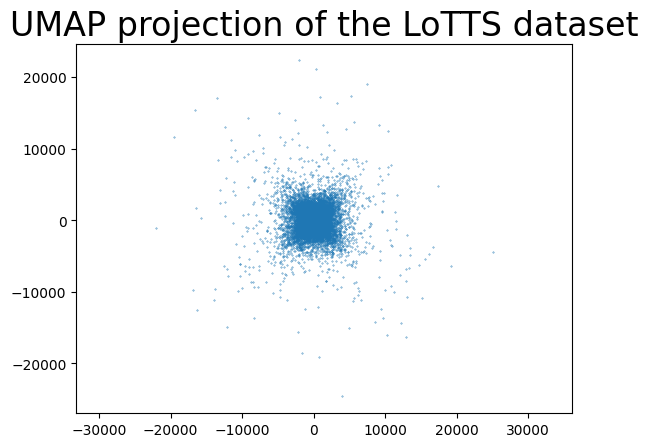

In [19]:
plt.scatter(
    emb[:, 0],
    emb[:, 1],
    s = 0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the LoTTS dataset', fontsize=24);

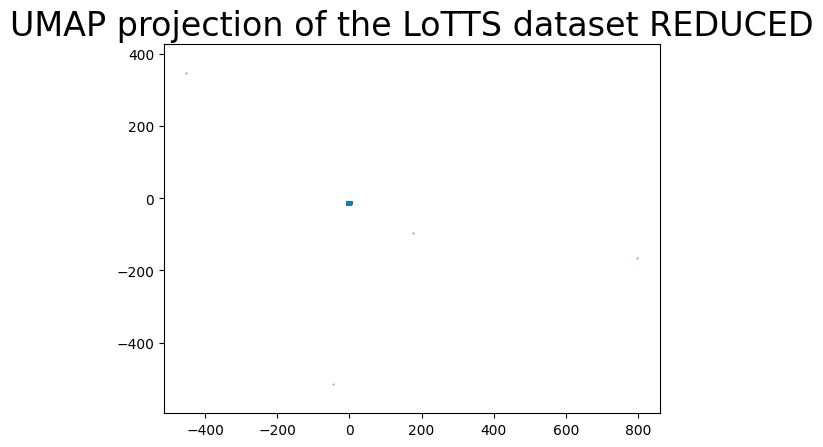

In [33]:
plt.scatter(
    emb_reduced[:, 0],
    emb_reduced[:, 1],
    s = 0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the LoTTS dataset REDUCED', fontsize=24);

In [19]:
import pandas as pd
info = pd.read_json("/home/tcecconello/radioimgs/radio-data-curation-ssl/LoTSS/cutouts/info.json", orient="index")


In [3]:
info.head()

,file_path,source_type,survey,mosaic_name,position,size
0,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 3968]",256
1,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4096]",256
2,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4224]",256
3,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4352]",256
4,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4480]",256


In [10]:
features[0]

array([3.92469382e+00, 3.07766327e+02, 0.00000000e+00, 0.00000000e+00,
       2.08609805e-01, 0.00000000e+00, 1.23483572e+01, 4.99718971e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.35893364e+01, 3.85185540e-01, 2.83549900e+01, 7.14349270e+00,
       1.74785309e+01, 7.58905869e+01, 4.12281364e-01, 8.21561813e+00,
       2.79623127e+01, 1.49009781e+02, 1.32031540e+02, 5.12405777e+01,
       6.77154005e-01, 4.86832440e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.90803738e+01, 1.68885975e+01, 0.00000000e+00,
       3.28999062e+01, 5.78097403e-01, 0.00000000e+00, 1.46164902e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.11583328e+00,
       3.82047772e-01, 2.45633335e+01, 0.00000000e+00, 0.00000000e+00,
       4.73337212e+01, 5.10609674e+00, 1.19163303e+01, 0.00000000e+00,
       7.51118469e+00, 2.71762447e+01, 1.20890293e+01, 6.01884842e+01,
       4.24669304e+01, 0.00000000e+00, 5.92184210e+00, 0.00000000e+00,
      

In [31]:
dist = np.linalg.norm(features[51]-features[50])

In [32]:
dist

0.094245456

In [36]:
sparsity_per_row = np.mean(features == 0, axis=1)
average_sparsity = np.mean(sparsity_per_row)
print(f"Sparsità media: {average_sparsity:.4f}")

Sparsità media: 0.3633


/tmp/ipykernel_2370712/2691274709.py:54: AltairDeprecationWarning:


Deprecated since `altair=5.0.0`. Use add_params instead.



alt.HConcatChart(...)
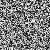
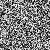
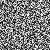
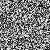
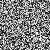
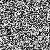
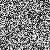
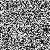
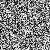
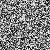

In [16]:
import altair as alt
import pandas as pd
import numpy as np
import base64
import io
from PIL import Image

# Genera dati di esempio
np.random.seed(42)
coordinates = np.random.rand(10, 2)
images = [np.random.rand(50, 50) for _ in range(10)]

def img_to_base64(img):
    img_scaled = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_scaled)
    buffer = io.BytesIO()
    pil_img.save(buffer, format='PNG')
    return f"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"

# Prepara DataFrame
df = pd.DataFrame({
    'x': coordinates[:,0], 
    'y': coordinates[:,1],
    'image': [img_to_base64(img) for img in images],
    'index': range(len(coordinates))
})

# Scatter plot base
points = alt.Chart(df).mark_point().encode(
    x=alt.X('x', title='X Coordinate'),
    y=alt.Y('y', title='Y Coordinate'),
    #color=alt.Color('index:N', scale=alt.Scale(scheme='blues')),
    tooltip=['index']
).properties(
    width=600,
    height=400,
    title='Interactive Image Coordinates'
)

# Seleziona punto al click
selector = alt.selection_point(fields=['index'])

# Mostra immagine selezionata
image_display = alt.Chart(df).mark_image(
    width=200,
    height=200
).encode(
    url='image:N'
).transform_filter(
    selector
)

# Combina scatter e display immagine
final_chart = points.add_selection(
    selector
) | image_display

# Mostra grafico
final_chart

In [15]:
import altair as alt
import pandas as pd
import numpy as np
import base64
import io
from PIL import Image

# Genera dati di esempio
np.random.seed(42)
coordinates = np.random.rand(100, 2)

# Crea file .npy di esempio se non esistono
for i in range(100):
    img = np.random.rand(50, 50)
    np.save(f'image_{i}.npy', img)

# Preparazione DataFrame
df = pd.DataFrame({
    'x': coordinates[:,0], 
    'y': coordinates[:,1],
    'image_path': [f'image_{i}.npy' for i in range(100)],
    'index': range(len(coordinates))
})

# Funzione per caricare immagine
def load_image(image_path):
    try:
        img = np.load(image_path)
        img_scaled = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_scaled)
        buffer = io.BytesIO()
        pil_img.save(buffer, format='PNG')
        return f"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return ""

# Scatter plot
points = alt.Chart(df).mark_point().encode(
    x=alt.X('x', title='X Coordinate'),
    y=alt.Y('y', title='Y Coordinate'),
    color=alt.Color('index:N', scale=alt.Scale(scheme='blues')),
    tooltip=['index', 'image_path']
).properties(
    width=600,
    height=400,
    title='Interactive Image Coordinates'
)

# Selettore punto
selector = alt.selection_point(fields=['index'])

# Mostra immagine selezionata
image_display = alt.Chart(df).mark_image(
    width=200,
    height=200
).encode(
    url=alt.datum.image_path
).transform_filter(
    selector
).transform_calculate(
    image_url=f'"{load_image(datum.image_path)}"'
).encode(
    url='image_url:N'
)

# Combina scatter e display immagine
final_chart = points.add_selection(selector) | image_display

# Mostra grafico
final_chart

NameError: name 'datum' is not defined

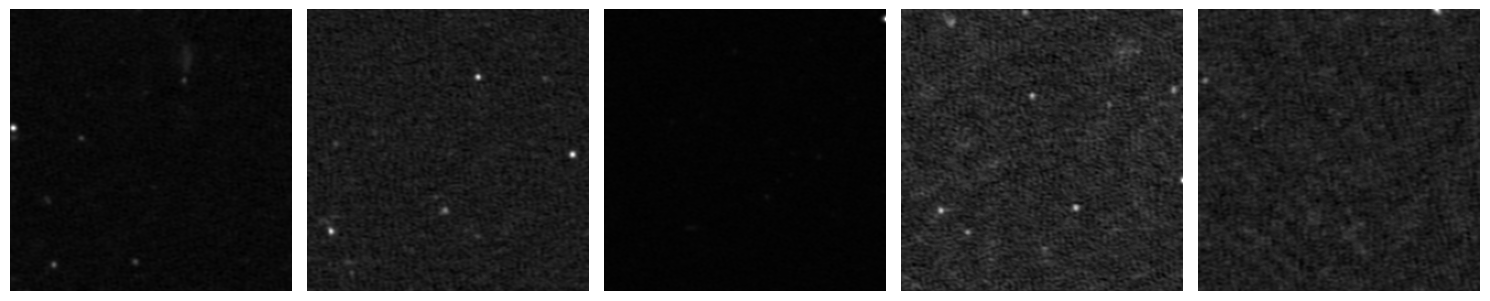

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



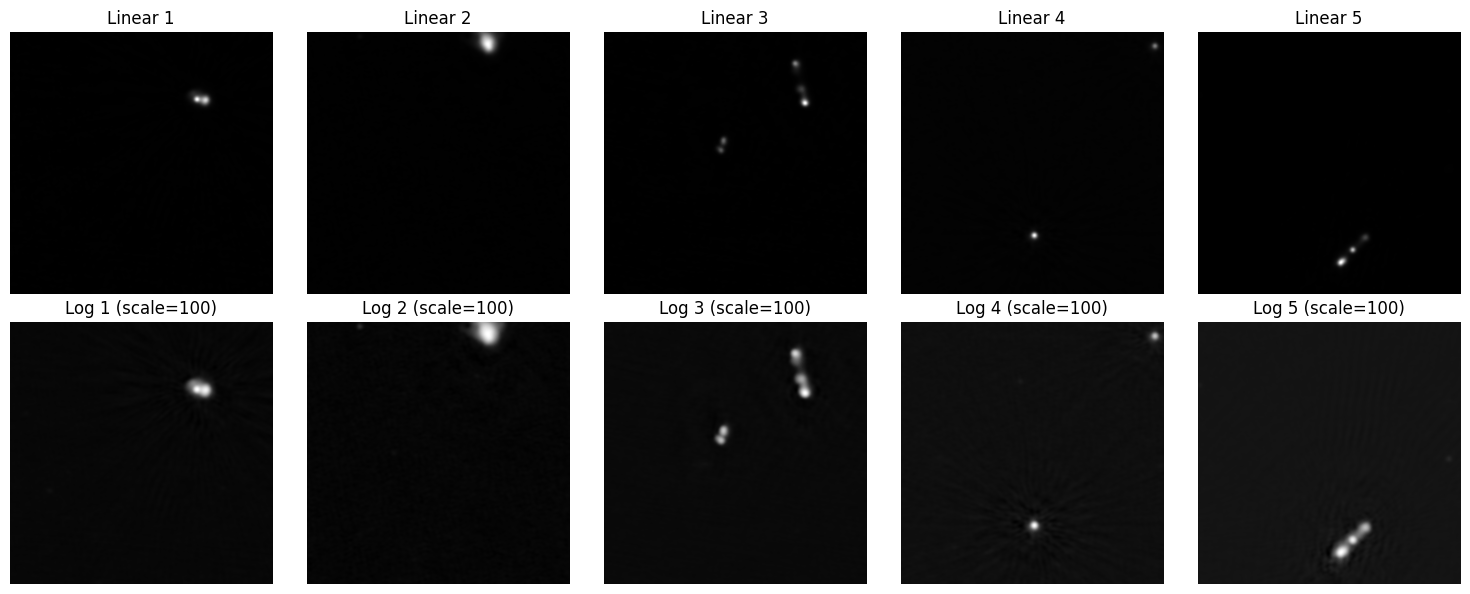

In [90]:
selected_rows = info.loc[sampled_indices].sample(5)

log_scale = 100  # Aumenta o diminuisci questo valore per cambiare la compressione

# Inizializza il subplot con due righe: una per la scala lineare e una per quella logaritmica
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, file_path in enumerate(selected_rows['file_path']):
    # Carica il file numpy
    img = np.load(file_path)
    
    # Normalizzazione in scala lineare
    img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Normalizzazione in scala logaritmica con parametro di scala
    img_log = np.log1p(log_scale * (img - np.min(img)))
    img_log_normalized = (img_log - np.min(img_log)) / (np.max(img_log) - np.min(img_log))
    
    # Visualizza l'immagine in scala lineare
    axes[0, idx].imshow(img_normalized, cmap='gray')
    axes[0, idx].set_title(f"Linear {idx+1}")
    axes[0, idx].axis('off')  # Rimuove gli assi
    
    # Visualizza l'immagine in scala logaritmica
    axes[1, idx].imshow(img_log_normalized, cmap='gray')
    axes[1, idx].set_title(f"Log {idx+1} (scale={log_scale})")
    axes[1, idx].axis('off')  # Rimuove gli assi

plt.tight_layout()
plt.show()